In [1]:
import os
!pip install kaggle -q
os.environ['KAGGLE_USERNAME'] = "raniavula"
os.environ['KAGGLE_KEY'] = "ec9f7f57eb2081504f161491a06ee570"
!kaggle datasets download "gunavenkatdoddi/eye-diseases-classification"

Dataset URL: https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification
License(s): ODbL-1.0


In [2]:
! unzip -q eye-diseases-classification.zip

In [3]:
import os
import cv2
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Corrected import statement
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report

In [4]:
labels = ["Normal", "Glaucoma", "Cataract", "Diabetic Retinopathy"]
counts = [1074,1007, 1038, 1098]

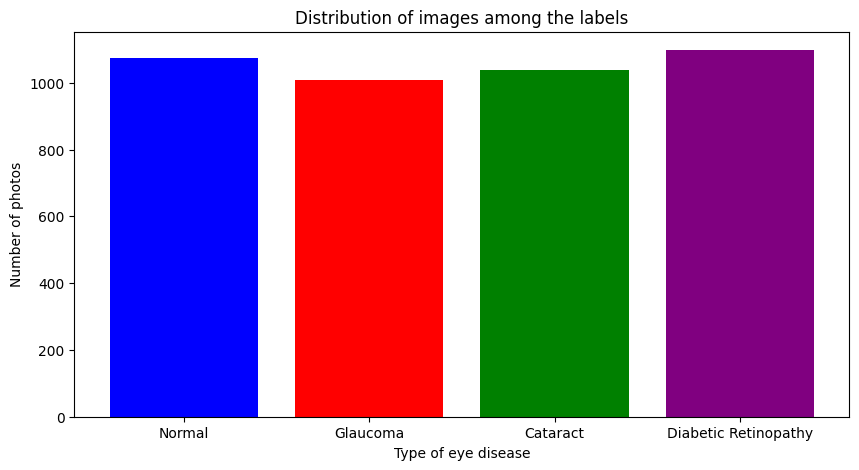

In [5]:
plt.figure(figsize=(10, 5))
plt.bar(labels, counts, color=['blue', 'red', 'green', 'purple'])
plt.xlabel("Type of eye disease")
plt.ylabel("Number of photos")
plt.title("Distribution of images among the labels")
plt.show()

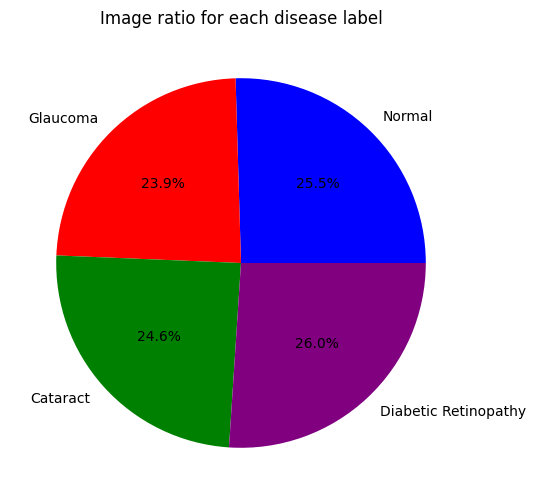

In [6]:
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=labels, autopct='%1.1f%%', colors=['blue', 'red', 'green', 'purple'])
plt.title("Image ratio for each disease label")
plt.show()

In [7]:
def visualize_images(path, target_size=(250, 250), num_images=5):
    image_filenames = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    selected_images = image_filenames[:num_images]
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3), facecolor='white')
    for i, image_filename in enumerate(selected_images):
        image_path = os.path.join(path, image_filename)
        image = Image.open(image_path)
        image = image.resize(target_size)
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)
    plt.tight_layout()
    plt.show()

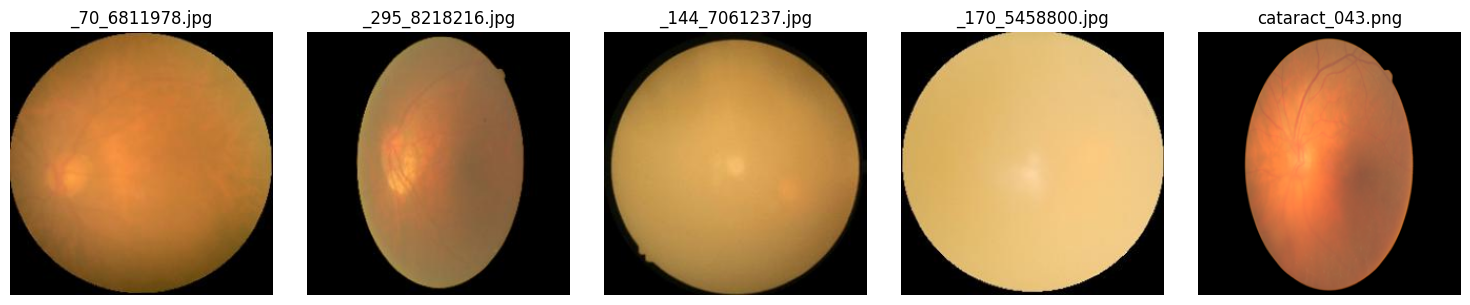

In [8]:
cataract = "/content/dataset/cataract"
visualize_images(cataract, num_images=5)

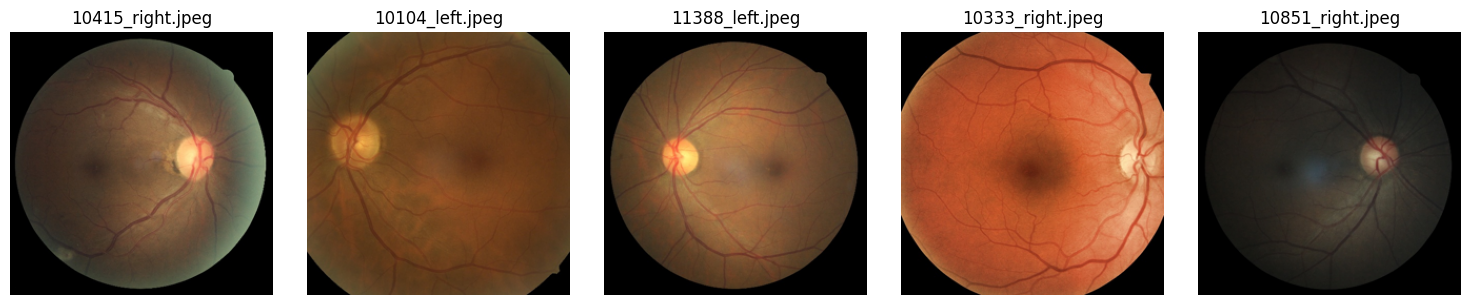

In [9]:
diabetic_retinopathy = "/content/dataset/diabetic_retinopathy"
visualize_images(diabetic_retinopathy, num_images=5)

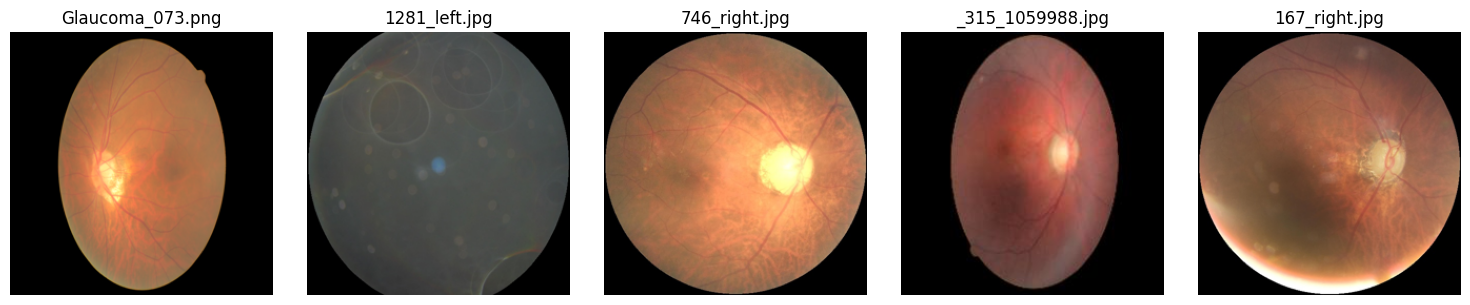

In [10]:
glaucoma = "/content/dataset/glaucoma"
visualize_images(glaucoma, num_images=5)

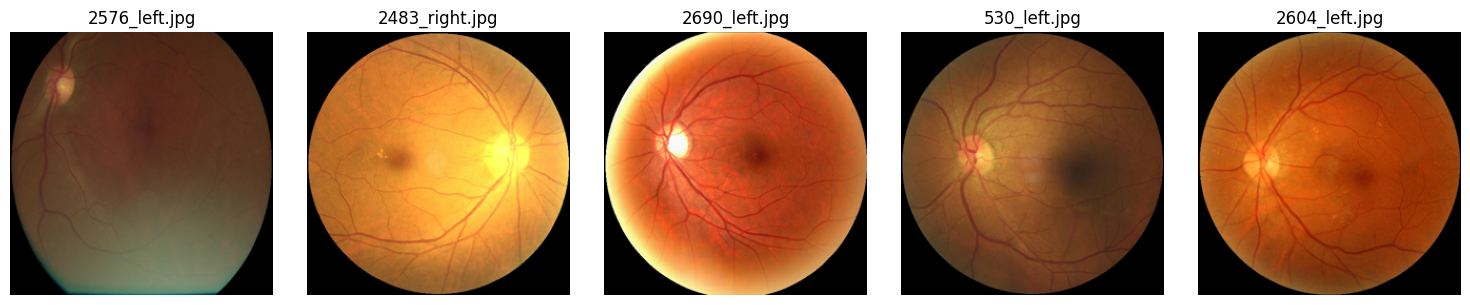

In [11]:
normal = "/content/dataset/normal"
visualize_images(normal, num_images=5)

In [12]:
data = "/content/dataset"
rescale = tf.keras.layers.Rescaling(1./255)
# Function to load dataset
def load_dataset(directory, subset=None, validation_split=0.25, batch_size=32, shuffle=True):
    return tf.keras.utils.image_dataset_from_directory(
        directory=directory,
        batch_size=batch_size,
        image_size=(256, 256),
        validation_split=validation_split if subset else None,
        subset=subset,
        seed=123,
        label_mode='categorical',
        shuffle=shuffle
    ).map(lambda x, y: (rescale(x), y))
train_ds = load_dataset(data, subset="training")
validation_ds = load_dataset(data, subset="validation")

Found 4217 files belonging to 4 classes.
Using 3163 files for training.
Found 4217 files belonging to 4 classes.
Using 1054 files for validation.


In [13]:
model = tf.keras.Sequential([
     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
     tf.keras.layers.MaxPooling2D((2, 2)),
     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
     tf.keras.layers.MaxPooling2D((2, 2)),
     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
     tf.keras.layers.MaxPooling2D((2, 2)),
     tf.keras.layers.Flatten(),
     tf.keras.layers.Dense(64, activation='relu'),
     tf.keras.layers.Reshape((64, 1)),  # Reshape for RNN input
     tf.keras.layers.SimpleRNN(32),  # Simple RNN layer
     tf.keras.layers.Dense(4, activation='softmax')  # Output layer
 ])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 64, 1)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn (SimpleRNN)               │ (None, 32)                  │           1,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,744,004 (14.28 MB)

 Trainable params: 3,744,004 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(train_ds,
                    validation_data=validation_ds,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping("val_accuracy", patience=5, verbose=1),
                        tf.keras.callbacks.ModelCheckpoint("Best model.keras", monitor="val_accuracy", save_best_only=True)
                    ],
                    epochs=50)

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 32s 234ms/step - accuracy: 0.3819 - loss: 1.2777 - val_accuracy: 0.5607 - val_loss: 0.8808
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - accuracy: 0.5877 - loss: 0.8487 - val_accuracy: 0.5939 - val_loss: 0.7696
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - accuracy: 0.6347 - loss: 0.7552 - val_accuracy: 0.6594 - val_loss: 0.7476
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - accuracy: 0.6670 - loss: 0.7234 - val_accuracy: 0.7002 - val_loss: 0.6670
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 187ms/step - accuracy: 0.7064 - loss: 0.6590 - val_accuracy: 0.7372 - val_loss: 0.6027
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 20s 183ms/step - accuracy: 0.7237 - loss: 0.6217 - val_accuracy: 0.7192 - val_loss: 0.5898
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 17s 175ms/step - accuracy: 0.7457 - loss: 0.5950 - val_accuracy: 0.7391 - val_loss: 0.5784
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 19s 189ms/step - accuracy: 0.7520 - loss: 0.5746 - val_accu

In [16]:
model.save('Final eye_disease_model.keras')

In [17]:
!sha256sum "Best model.keras"

8e1acd57c7f9df9b2065f61cf795a761345a37fd0fe1872a41dd775edde9327e  Best model.keras


In [18]:
best_model = tf.keras.models.load_model("Best model.keras")

In [19]:
best_model.evaluate(validation_ds, return_dict=True)

33/33 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 0.8403 - loss: 0.4623


{'accuracy': 0.840607225894928, 'loss': 0.4630476236343384}

In [20]:
train_ds.cardinality()

<tf.Tensor: shape=(), dtype=int64, numpy=99>

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
Raw Predictions: [[1.1378992e-04 9.9903643e-01 3.2077054e-04 5.2904541e-04]]
Predicted Class: Diabetic Retinopathy
Confidence: 99.90


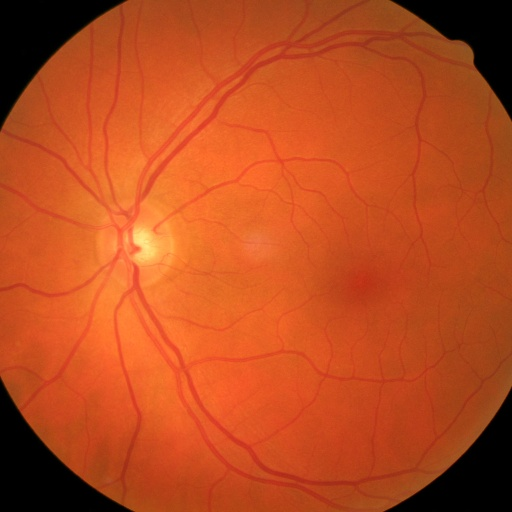

In [22]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("/content/Best model.keras")  # Ensure correct model path

# Class labels
class_labels = ["Cataract", "Diabetic Retinopathy", "Glaucoma", "Normal Image"]

def predict_image(image_path):
    """Predicts the class of an input image."""
    img = tf.keras.utils.load_img(image_path, target_size=(256, 256))
    img = tf.keras.utils.img_to_array(img, dtype=np.float64) / 255.0
    predictions = model.predict(np.array([img]))

    # Print raw predictions for debugging
    print(f"Raw Predictions: {predictions}")

    class_index = np.argmax(predictions)  # Get the highest probability index
    return class_labels[class_index], np.max(predictions)

# Example usage
image_path = "/content/dataset/diabetic_retinopathy/10031_left.jpeg"  # Replace with actual image path
result, confidence = predict_image(image_path)
print(f"Predicted Class: {result}\nConfidence: {confidence * 100:.2f}")

tf.keras.utils.load_img(image_path)